### 0.0. Dependencies

In [19]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from shapely.geometry import Point
from rasterstats import zonal_stats
from rasterio.transform import from_origin
import tempfile
import os

### 1.1. Mobile App Data

#### 1.1.1. Loading in

In [28]:
## load mobile csv
mobile_csv = pd.read_csv("Data/Mobile_App_Data_Extract.csv")

In [29]:
print(len(mobile_csv))

47207158


In [30]:
#check cols
print(mobile_csv.columns)

Index(['id', 'year', 'month', 'day', 'hour', 'acorn_group', 'home_country',
       'work_country', 'home_distance_band_name', 'work_distance_band_name',
       'events'],
      dtype='object')


In [31]:
## load local footprint data
locF_lookup = pd.read_csv("Data/LOCF_ID_Look_Up.csv")
locF_data = pd.read_csv("Data/Retail_Footprint_24_INTS_Local_Footprint.csv")

In [32]:
# check 
display(locF_lookup.sort_values(by='id').head())
print(locF_data.columns)


,id,LocF_CentreID,LocF_CentreName,CentroidX,CentroidY
1544,1,01-0001-22,London - Tooting,-0.165694,51.427946
183,2,01-0002-22,London - East Ham,0.052224,51.539347
2987,3,01-0003-22,London - Old Street,-0.090509,51.525846
803,4,01-0004-22,Hoxton,-0.093991,51.530838
2519,5,01-0005-22,London - Shepherds Bush,-0.225495,51.502832


Index(['Centre_ID', 'Name', 'Short Name', 'Region', 'Major Class',
       'Major Class Name', 'Minor Class', 'Minor Class Name', 'Base Score',
       'Retail Footprint Score', 'National Rank', 'Regional Rank',
       'Total UK Centres', 'Total Region Centres', 'Total Class Centres',
       'Centre Type Rank', 'Residential Population (Weighted Catchment)',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       '_Location_X', '_Location_Y', 'Tourism Score',
       'Local_Footprint_Centre_ID', 'Local_Footprint_Centre_Name', 'Town',
       'Universe_Region', 'Convenience_Score', 'Retail_Footprint_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Pr

In [33]:
## load locF shapefiles
locF_gdf = gpd.read_file("Data/Local_Footprint_Boundary.shp")
locF_gdf = locF_gdf.to_crs(epsg=27700)  # British National Grid

#### 1.1.2. LocF wrangling

Check for duplicates:

In [34]:
# check how many duplicate 'id' values exist
duplicate_ids = locF_lookup['id'].duplicated().sum()
print(f"Duplicate ids in locF_lookup: {duplicate_ids}")
# check duplicates in Local_Footprint_Centre_ID
duplicate_centres = locF_data['Local_Footprint_Centre_ID'].duplicated().sum()
print(f"Duplicate ids in locF_data: {duplicate_centres}")

Duplicate ids in locF_lookup: 0
Duplicate ids in locF_data: 92


In [35]:
## check for recurring Local Footprint Keys
recurring_keys = locF_data['Local_Footprint_Centre_ID'].value_counts()
recurring_keys = recurring_keys[recurring_keys > 1]
print(recurring_keys)

Local_Footprint_Centre_ID
01-0466-22    3
01-0330-22    3
01-0021-22    2
01-0001-22    2
08-0004-22    2
             ..
01-0015-22    2
55-0185-22    2
04-0002-22    2
01-0239-22    2
34-0222-22    2
Name: count, Length: 90, dtype: int64


In [36]:
# example dupliates
display(locF_data[locF_data['Local Footprint Key'] == '01-0466-22'])

,Centre_ID,Name,Short Name,Region,Major Class,Major Class Name,Minor Class,Minor Class Name,Base Score,Retail Footprint Score,...,Universe_Longitude,Universe_Latitude,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name,Local Footprint Key,Local Footprint Name
78,01-219,London - Shoreditch,Shoreditch,London,8,London Suburban Centres,22,Inner London Centres,433,449,...,-0.082537,51.523251,1,City Centre,110,Worker,1,Not seasonal,01-0466-22,London - Shoreditch - Scr
230,01-048,London - Old Street,Old Street,London,8,London Suburban Centres,22,Inner London Centres,157,165,...,-0.082537,51.523251,1,City Centre,110,Worker,1,Not seasonal,01-0466-22,London - Shoreditch - Scr
645,01-237,City of London - Broadgate,Broadgate,London,8,London Suburban Centres,19,London Workplaces,553,601,...,-0.082537,51.523251,1,City Centre,110,Worker,1,Not seasonal,01-0466-22,London - Shoreditch - Scr


Create new df without recurring Local Footprint IDs:

In [37]:
# column groups by aggregation type
group_key = 'Local_Footprint_Centre_ID'

cols_to_keep = [
    'Local Footprint Name','Region', 'Base Score', 'Retail Footprint Score', 'Residential Population (Weighted Catchment)',
    'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude', 'Tourism Score',
    'Local_Footprint_Centre_ID', 'Local_Footprint_Centre_Name', 'Convenience_Score',
    'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
    'Auto_Score', 'Services_Provided:_Convenience_Food',
    'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
    'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
    'Services_Provided:_Chemist', 'Services_Provided:_Banking',
    'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
    'Services_Provided:_Other_Convenience_Services',
    'Services_Provided:_Rail_or_Tube_Access',
    'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
    'Services_Provided:_Auto_Dealers', 'Services_Provided:_DIY', 'Major_Class',
    'Major_Class_Name', 'Minor_Class', 'Minor_Class_Name',
    'Seasonality_Class', 'Seasonality_Class_Name'
]

# ensure the dataframe only has relevant columns
df = locF_data[cols_to_keep].copy()

# define aggregation rules
agg_rules = {
    'Residential Population (Weighted Catchment)': 'sum',
    'Retail Footprint Score': 'mean',
    'Base Score': 'mean',
    'Tourism Score': 'mean',
    'Convenience_Score': 'mean',
    'Retail_Footprint_Comparison_Retailer_Score': 'mean',
    'Leisure_Footprint_Score': 'mean',
    'Auto_Score': 'mean'
}

# for all other columns, keep the first occurrence
for col in cols_to_keep:
    if col not in agg_rules and col != group_key:
        agg_rules[col] = 'first'

# columns where any True → final is True
bool_cols = [
    'Services_Provided:_Convenience_Food',
    'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
    'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
    'Services_Provided:_Chemist', 'Services_Provided:_Banking',
    'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
    'Services_Provided:_Other_Convenience_Services',
    'Services_Provided:_Rail_or_Tube_Access',
    'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
    'Services_Provided:_Auto_Dealers', 'Services_Provided:_DIY'
]

for col in bool_cols:
    df[col] = df[col].apply(lambda x: True if x == 'T' else False)
    agg_rules[col] = 'any'

# group and aggregate
df_cleaned = df.groupby(group_key, as_index=False).agg(agg_rules)

## check for recurring Local Footprint Keys
recurring_keys = df_cleaned['Local_Footprint_Centre_ID'].value_counts()
recurring_keys = recurring_keys[recurring_keys > 1]
print(recurring_keys)
print(df_cleaned.columns)
display(df_cleaned.head())

Series([], Name: count, dtype: int64)
Index(['Local_Footprint_Centre_ID',
       'Residential Population (Weighted Catchment)', 'Retail Footprint Score',
       'Base Score', 'Tourism Score', 'Convenience_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Local Footprint Name', 'Region',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       'Local_Footprint_Centre_Name', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
       'Services_Provided:_Other_Convenience_Services',
       'Services_Provided:_Rail_or_Tube_Access',
       'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
       'Services_Provided:_Auto_D

,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,Tourism Score,Convenience_Score,Retail_Footprint_Comparison_Retailer_Score,Leisure_Footprint_Score,Auto_Score,Local Footprint Name,...,Services_Provided:_Comparison_Retail,Services_Provided:_Leisure,Services_Provided:_Auto_Dealers,Services_Provided:_DIY,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name
0,01-0001-22,80102,394.5,366.0,65.703928,453.0,254.0,684.0,0.0,London - Tooting,...,True,True,False,True,4,Local High Street,401,Urban High Street,1,Not seasonal
1,01-0002-22,53781,389.0,358.0,25.178087,374.0,227.0,409.0,0.0,London - East Ham,...,True,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
2,01-0003-22,38043,307.0,295.0,670.667835,340.0,51.0,307.0,0.0,London - Old Street,...,True,True,False,False,1,City Centre,110,Worker,1,Not seasonal
3,01-0004-22,7862,165.0,157.0,715.736173,326.0,0.0,11.0,0.0,Hoxton,...,False,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
4,01-0005-22,13418,423.0,398.0,160.154406,368.0,169.0,698.0,0.0,London - Shepherds Bush,...,True,True,False,True,1,City Centre,103,Secondary Retail,1,Not seasonal


#### 1.1.3. Mobile wrangling

Date-time conversion:

In [38]:
print(mobile_csv['hour'].unique())

[ 9  5 11 10 15 22 16  8 14 21 19 13  6 18 17 20  4 12  0  7 23  1  3  2]


In [39]:
mobile_csv_convert = mobile_csv.copy()
mobile_csv_convert['datetime'] = pd.to_datetime(dict(
    year=mobile_csv_convert['year'],
    month=mobile_csv_convert['month'],
    day=mobile_csv_convert['day'],
    hour=mobile_csv_convert['hour']
))
mobile_csv_convert = mobile_csv_convert.drop(columns=['year', 'month', 'day', 'hour'])


Check the data:

In [40]:
display(mobile_csv_convert.head())

,id,acorn_group,home_country,work_country,home_distance_band_name,work_distance_band_name,events,datetime
0,27980,N,United Kingdom,United Kingdom,50 km +,50 km +,22,2024-04-05 09:00:00
1,20944,R,United Kingdom,United Kingdom,00 - 01 km,00 - 01 km,25,2024-02-14 09:00:00
2,3864,N,United Kingdom,United Kingdom,00 - 01 km,50 km +,3,2024-01-23 05:00:00
3,1334,G,United Kingdom,United Kingdom,05 - 10 km,00 - 01 km,26,2024-08-23 11:00:00
4,8903,F,United Kingdom,United Kingdom,40 - 45 km,40 - 45 km,21,2024-02-21 10:00:00


In [41]:
display(mobile_csv_convert.sort_values(by='id').head())

,id,acorn_group,home_country,work_country,home_distance_band_name,work_distance_band_name,events,datetime
25310044,1,E,United Kingdom,United Kingdom,01 - 05 km,00 - 01 km,4,2024-03-29 14:00:00
251,1,G,United Kingdom,United Kingdom,10 - 15 km,50 km +,21,2024-10-31 13:00:00
40660053,1,N,United Kingdom,United Kingdom,01 - 05 km,0 - 05 km,2,2024-02-14 14:00:00
30009782,1,H,United Kingdom,United Kingdom,01 - 05 km,00 - 01 km,5,2024-04-17 00:00:00
45286495,1,J,United Kingdom,United Kingdom,05 - 10 km,0 - 05 km,1,2024-10-23 13:00:00


In [42]:
df_filtered = mobile_csv_convert[mobile_csv_convert['id'] == 20944].sort_values(by='datetime')
display(df_filtered.iloc[50:60][['datetime']])

,datetime
17593705,2024-01-01 16:00:00
38815683,2024-01-01 16:00:00
26216004,2024-01-01 16:00:00
10485045,2024-01-01 17:00:00
32343640,2024-01-01 17:00:00
24582281,2024-01-01 17:00:00
28033286,2024-01-01 17:00:00
33152362,2024-01-01 17:00:00
46628795,2024-01-01 18:00:00
40776243,2024-01-01 18:00:00


Plot hourly footfall:

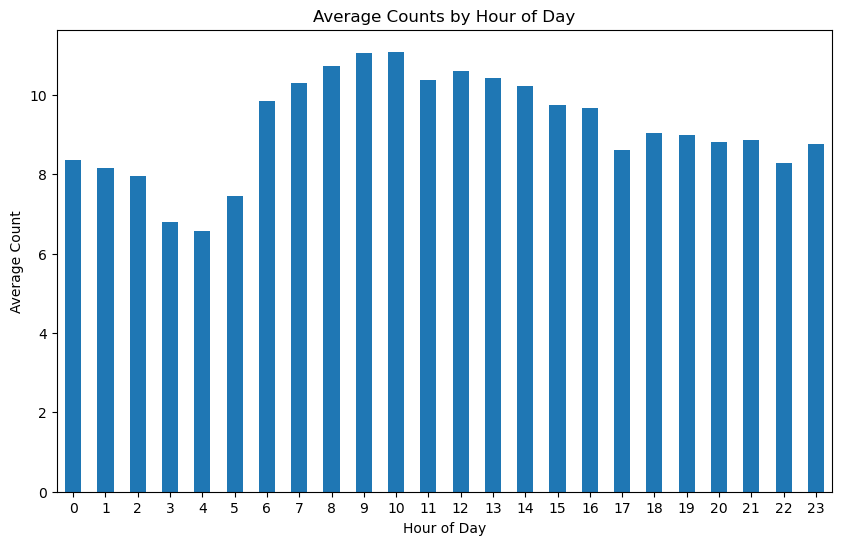

In [43]:
# extract hour from datetime
df_filtered['hour'] = df_filtered['datetime'].dt.hour

# group by hour and compute average count
avg_counts_by_hour = df_filtered.groupby('hour')['events'].mean()

# plot
plt.figure(figsize=(10,6))
avg_counts_by_hour.plot(kind='bar')
plt.xlabel('Hour of Day')
plt.ylabel('Average Count')
plt.title('Average Counts by Hour of Day')
plt.xticks(rotation=0)
plt.show()

Generate daily footfall counts:

In [44]:
# extract date (without time) from datetime
mobile_csv_convert['date'] = mobile_csv_convert['datetime'].dt.date

# group by date and id, then sum events
mobile_daily = (
    mobile_csv_convert
    .groupby(['date', 'id'])['events']
    .sum()
    .reset_index()
)

display(mobile_csv_convert)
display(mobile_daily.head())
len(mobile_daily)

,id,acorn_group,home_country,work_country,home_distance_band_name,work_distance_band_name,events,datetime,date
0,27980,N,United Kingdom,United Kingdom,50 km +,50 km +,22,2024-04-05 09:00:00,2024-04-05
1,20944,R,United Kingdom,United Kingdom,00 - 01 km,00 - 01 km,25,2024-02-14 09:00:00,2024-02-14
2,3864,N,United Kingdom,United Kingdom,00 - 01 km,50 km +,3,2024-01-23 05:00:00,2024-01-23
3,1334,G,United Kingdom,United Kingdom,05 - 10 km,00 - 01 km,26,2024-08-23 11:00:00,2024-08-23
4,8903,F,United Kingdom,United Kingdom,40 - 45 km,40 - 45 km,21,2024-02-21 10:00:00,2024-02-21
...,...,...,...,...,...,...,...,...,...
47207153,18929,U,United Kingdom,United Kingdom,01 - 05 km,00 - 01 km,1,2024-01-26 10:00:00,2024-01-26
47207154,48,S,United Kingdom,United Kingdom,10 - 15 km,00 - 01 km,2,2024-03-21 15:00:00,2024-03-21
47207155,2577,E,United Kingdom,United Kingdom,05 - 10 km,05 - 10 km,1,2024-06-06 11:00:00,2024-06-06
47207156,26004,K,United Kingdom,United Kingdom,01 - 05 km,50 km +,2,2024-07-07 14:00:00,2024-07-07


,date,id,events
0,2024-01-01,1,1714
1,2024-01-01,2,3148
2,2024-01-01,3,692
3,2024-01-01,4,27
4,2024-01-01,5,2164


1059996

Determine weekday/weekend season:

In [ ]:
mobile_daily['date'] = pd.to_datetime(mobile_daily['date'])

# add weekend column (True if Saturday or Sunday)
mobile_daily['weekend'] = mobile_daily['date'].dt.dayofweek >= 5

# define a function to assign seasons (Northern Hemisphere, 2024)
def get_season(date):
    Y = date.year
    if pd.Timestamp(f'{Y}-03-20') <= date < pd.Timestamp(f'{Y}-06-20'):
        return 'Spring'
    elif pd.Timestamp(f'{Y}-06-20') <= date < pd.Timestamp(f'{Y}-09-22'):
        return 'Summer'
    elif pd.Timestamp(f'{Y}-09-22') <= date < pd.Timestamp(f'{Y}-12-21'):
        return 'Autumn'
    else:
        return 'Winter'

# add season column
mobile_daily['season'] = mobile_daily['date'].apply(get_season)

# display updated DataFrame
display(mobile_daily.head())

,date,id,events,weekend,season
0,2024-01-01,1,1714,False,Winter
1,2024-01-01,2,3148,False,Winter
2,2024-01-01,3,692,False,Winter
3,2024-01-01,4,27,False,Winter
4,2024-01-01,5,2164,False,Winter


Determine holidays:

In [ ]:
# define UK bank holidays in 2024
uk_holidays_2024 = pd.to_datetime([
    '2024-01-01',  # New Year’s Day
    '2024-03-29',  # Good Friday
    '2024-04-01',  # Easter Monday
    '2024-05-06',  # Early May bank holiday
    '2024-05-27',  # Spring bank holiday
    '2024-08-26',  # Summer bank holiday
    '2024-12-25',  # Christmas Day
    '2024-12-26'   # Boxing Day
])

# add holiday column (True if the date is a holiday)
mobile_daily['holiday'] = mobile_daily['date'].isin(uk_holidays_2024)

# display updated df
display(mobile_daily.head())

#### 1.1.4. Merging

Mobile & locF data merge:

In [46]:
## join locF id with mobile data based on lookup table 
mobile_locF = mobile_daily.merge(locF_lookup[['id', 'LocF_CentreID']], how='left', on='id')

In [47]:
## join locF data with mobile data
mobile_locF = mobile_locF.merge(df_cleaned, how='left', left_on='LocF_CentreID', right_on='Local_Footprint_Centre_ID')
mobile_locF = mobile_locF.drop(columns=['LocF_CentreID']) # drop redundant column

In [48]:
# check the number or rows matches the initial mobile data 
print(len(mobile_daily))
print(len(mobile_locF))

1059996
1059996


In [49]:
# check cols
print(mobile_locF.columns)


Index(['date', 'id', 'events', 'weekend', 'season',
       'Local_Footprint_Centre_ID',
       'Residential Population (Weighted Catchment)', 'Retail Footprint Score',
       'Base Score', 'Tourism Score', 'Convenience_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Local Footprint Name', 'Region',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       'Local_Footprint_Centre_Name', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
       'Services_Provided:_Other_Convenience_Services',
       'Services_Provided:_Rail_or_Tube_Access',
       'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
       'Services_Pr

In [50]:
# display all columns and their values for the first few rows
with pd.option_context('display.max_columns', None, 'display.width', None):
    display(mobile_locF.head())

,date,id,events,weekend,season,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,Tourism Score,Convenience_Score,Retail_Footprint_Comparison_Retailer_Score,Leisure_Footprint_Score,Auto_Score,Local Footprint Name,Region,Spend Per Head (Residential),Sparsity,Longitude,Latitude,Local_Footprint_Centre_Name,Services_Provided:_Convenience_Food,Services_Provided:_Specialist_Food_Store_/_Off_Licence,Services_Provided:_Post_Office,Services_Provided:_Newsagent,Services_Provided:_Chemist,Services_Provided:_Banking,Services_Provided:_Petrol,Services_Provided:_Fast_Food_/_Takeaway,Services_Provided:_Other_Convenience_Services,Services_Provided:_Rail_or_Tube_Access,Services_Provided:_Comparison_Retail,Services_Provided:_Leisure,Services_Provided:_Auto_Dealers,Services_Provided:_DIY,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name
0,2024-01-01,1,1714,False,Winter,01-0001-22,80102,394.5,366.0,65.703928,453.0,254.0,684.0,0.0,London - Tooting,London,1933.087727,5 - Urban Dense (London),-0.166467,51.428020,London - Tooting,True,True,True,True,True,True,True,True,True,True,True,True,False,True,4,Local High Street,401,Urban High Street,1,Not seasonal
1,2024-01-01,2,3148,False,Winter,01-0002-22,53781,389.0,358.0,25.178087,374.0,227.0,409.0,0.0,London - East Ham,London,1733.492583,5 - Urban Dense (London),0.054717,51.540270,London - East Ham,True,True,True,True,True,True,True,True,True,True,True,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
2,2024-01-01,3,692,False,Winter,01-0003-22,38043,307.0,295.0,670.667835,340.0,51.0,307.0,0.0,London - Old Street,London,1812.007827,5 - Urban Dense (London),-0.075624,51.528560,London - Old Street,True,True,True,True,True,False,True,True,True,True,True,True,False,False,1,City Centre,110,Worker,1,Not seasonal
3,2024-01-01,4,27,False,Winter,01-0004-22,7862,165.0,157.0,715.736173,326.0,0.0,11.0,0.0,Hoxton,London,1892.654325,5 - Urban Dense (London),-0.091799,51.526522,Hoxton,True,True,False,True,False,False,True,True,True,False,False,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
4,2024-01-01,5,2164,False,Winter,01-0005-22,13418,423.0,398.0,160.154406,368.0,169.0,698.0,0.0,London - Shepherds Bush,London,1972.601453,5 - Urban Dense (London),-0.227470,51.502096,London - Shepherds Bush,True,True,True,True,True,True,True,True,True,True,True,True,False,True,1,City Centre,103,Secondary Retail,1,Not seasonal


Check for NAs:

In [51]:
# print NA sums
display(mobile_locF.isna().sum())

date                                                          0
id                                                            0
events                                                        0
weekend                                                       0
season                                                        0
Local_Footprint_Centre_ID                                     0
Residential Population (Weighted Catchment)                   0
Retail Footprint Score                                        0
Base Score                                                    0
Tourism Score                                             10533
Convenience_Score                                             0
Retail_Footprint_Comparison_Retailer_Score                    0
Leisure_Footprint_Score                                       0
Auto_Score                                                    0
Local Footprint Name                                          0
Region                                  

In [52]:
na_tourism = mobile_locF[mobile_locF['Tourism Score'].isna()]
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(na_tourism)

,date,id,events,weekend,season,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,Tourism Score,Convenience_Score,Retail_Footprint_Comparison_Retailer_Score,Leisure_Footprint_Score,Auto_Score,Local Footprint Name,Region,Spend Per Head (Residential),Sparsity,Longitude,Latitude,Local_Footprint_Centre_Name,Services_Provided:_Convenience_Food,Services_Provided:_Specialist_Food_Store_/_Off_Licence,Services_Provided:_Post_Office,Services_Provided:_Newsagent,Services_Provided:_Chemist,Services_Provided:_Banking,Services_Provided:_Petrol,Services_Provided:_Fast_Food_/_Takeaway,Services_Provided:_Other_Convenience_Services,Services_Provided:_Rail_or_Tube_Access,Services_Provided:_Comparison_Retail,Services_Provided:_Leisure,Services_Provided:_Auto_Dealers,Services_Provided:_DIY,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name
305,2024-01-01,1350,1348,False,Winter,02-0153-22,0,343.0,300.0,NaN,50.0,249.0,70.0,0.0,London Heathrow Airport -,London,0.00000,5 - Urban Dense (London),-0.487946,51.471608,London Heathrow Airport - Terminal 5,True,True,True,False,True,False,False,True,False,False,True,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
324,2024-01-01,1459,1447,False,Winter,02-0262-22,0,182.0,160.0,NaN,37.0,157.0,68.0,0.0,London Heathrow Airport -,London,0.00000,5 - Urban Dense (London),-0.451302,51.470321,London Heathrow Airport - Terminal 2,False,True,False,False,True,False,False,True,True,True,True,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
359,2024-01-01,1614,748,False,Winter,02-0416-22,0,215.0,189.0,NaN,20.0,97.0,44.0,0.0,London Heathrow Airport -,London,0.00000,5 - Urban Dense (London),-0.458626,51.470903,London Heathrow Airport - Terminal 3,True,True,False,False,True,False,False,True,True,False,True,True,False,False,4,Local High Street,401,Urban High Street,6,Winter months
700,2024-01-01,5834,101,False,Winter,05-0125-22,0,29.0,29.0,NaN,13.0,0.0,99.0,0.0,Doncaster - Dome Leisure,Yorkshire and The Humber,0.00000,6 - Retail Park,-1.104043,53.514081,Doncaster - Dome Leisure Park,True,False,False,False,False,False,True,True,False,False,False,True,False,False,3,Retail Park,304,Leisure Park,1,Not seasonal
733,2024-01-01,6156,32,False,Winter,05-0444-24,20252,138.0,161.0,NaN,26.0,103.0,35.0,0.0,Stocksbridge - Fox Valley,Yorkshire and The Humber,2155.71929,2 - Small Urban,-1.586133,53.482745,Stocksbridge - Fox Valley Shopping Park,True,True,False,True,True,False,False,True,True,False,True,True,False,True,0,None,0,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1059544,2024-12-31,30069,474,False,Winter,44-0500-22,0,343.0,300.0,NaN,1.0,0.0,0.0,0.0,London Heathrow Airport -,London,0.00000,5 - Urban Dense (London),-0.487946,51.471608,London Heathrow Airport - Terminal 5 Tube Station,False,False,False,False,False,False,False,False,False,True,False,False,False,False,5,Local Parade,109,Convenience and Services,1,Not seasonal
1059562,2024-12-31,30277,20,False,Winter,45-0067-22,0,22.0,23.0,NaN,21.0,7.0,35.0,0.0,Corley Services,West Midlands,0.00000,2 - Small Urban,-1.546500,52.471368,Corley Services,True,False,False,False,False,False,True,True,False,False,True,True,False,False,7,Transient,701,Motorway,2,Warm months
1059577,2024-12-31,30667,580,False,Winter,46-0053-22,0,188.0,213.0,NaN,49.0,140.0,144.0,0.0,London Gatwick Airport -,South East,0.00000,2 - Small Urban,-0.162786,51.156015,London Gatwick Airport - South Terminal,True,True,False,False,True,False,True,True,True,False,True,True,False,False,4,Local High Street,401,Urban High Street,1,Not seasonal
1059585,2024-12-31,30895,95,False,Winter,46-0281-22,0,188.0,213.0,NaN,1.0,1.0,5.0,0.0,London Gatwick Airport Ra,South East,0.00000,2 - Small Urban,-0.162786,51.156015,London Gatwick Airport Railway Station,Fals

In [53]:
na_class = mobile_locF[mobile_locF['Major_Class_Name'].isna()]
with pd.option_context('display.max_rows', 10, 'display.max_columns', None):
    display(na_class)

,date,id,events,weekend,season,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,Tourism Score,Convenience_Score,Retail_Footprint_Comparison_Retailer_Score,Leisure_Footprint_Score,Auto_Score,Local Footprint Name,Region,Spend Per Head (Residential),Sparsity,Longitude,Latitude,Local_Footprint_Centre_Name,Services_Provided:_Convenience_Food,Services_Provided:_Specialist_Food_Store_/_Off_Licence,Services_Provided:_Post_Office,Services_Provided:_Newsagent,Services_Provided:_Chemist,Services_Provided:_Banking,Services_Provided:_Petrol,Services_Provided:_Fast_Food_/_Takeaway,Services_Provided:_Other_Convenience_Services,Services_Provided:_Rail_or_Tube_Access,Services_Provided:_Comparison_Retail,Services_Provided:_Leisure,Services_Provided:_Auto_Dealers,Services_Provided:_DIY,Major_Class,Major_Class_Name,Minor_Class,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name
137,2024-01-01,418,153,False,Winter,01-0417-24,7862,165.0,157.0,715.736173,20.0,0.0,16.0,0.0,Hoxton - Murray Grove,London,1892.654325,5 - Urban Dense (London),-0.091799,51.526522,Hoxton - Murray Grove,True,True,True,False,True,False,False,True,True,False,False,True,False,False,0,None,0,None,0,None
179,2024-01-01,615,65,False,Winter,01-0610-24,30897,211.0,219.0,71.370285,9.0,94.0,9.0,0.0,London - Bell Green,London,1810.689108,6 - Retail Park,-0.034461,51.429477,London - Bell Green,True,False,False,False,False,False,False,True,True,False,True,True,False,True,0,None,0,None,0,None
235,2024-01-01,1074,75,False,Winter,01-1063-24,38043,307.0,295.0,670.667835,2.0,0.0,3.0,0.0,Hoxton - New North Road,London,1812.007827,5 - Urban Dense (London),-0.075624,51.528560,Hoxton - New North Road,True,False,False,True,False,False,False,False,False,False,False,True,False,False,0,None,0,None,0,None
236,2024-01-01,1076,22,False,Winter,01-1064-24,3847,162.0,153.0,378.022527,1.0,0.0,8.0,0.0,Kensington - West Cromwel,London,2184.499509,5 - Urban Dense (London),-0.192340,51.490112,Kensington - West Cromwell Road,False,False,False,False,False,False,False,False,False,False,False,True,False,False,0,None,0,None,0,None
237,2024-01-01,1078,20,False,Winter,01-1065-24,3847,162.0,153.0,378.022527,1.0,0.0,4.0,0.0,London - Kensington - Cro,London,2184.499509,5 - Urban Dense (London),-0.192340,51.490112,London - Kensington - Cromwell Road - 2,False,True,False,False,False,False,False,False,False,False,False,True,False,False,0,None,0,None,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1058725,2024-12-31,17968,181,False,Winter,23-0460-24,30349,240.0,268.0,49.804403,23.0,57.0,24.0,0.0,Maldon - Blackwater Retai,East of England,2237.503734,2 - Small Urban,0.677783,51.733167,Maldon - Blackwater Retail Park,True,True,False,False,True,False,True,True,True,False,True,True,False,False,0,None,0,None,0,None
1058774,2024-12-31,18624,12,False,Winter,24-0126-24,7806,104.0,106.0,10.176248,6.0,8.0,17.0,0.0,Gloucester - Quedgeley -,South West,1989.192093,3 - Urban,-2.277118,51.826750,Gloucester - Quedgeley - Bristol Road,False,False,True,False,False,False,True,False,False,False,True,True,False,False,0,None,0,None,0,None
1058831,2024-12-31,19223,11,False,Winter,25-0320-24,7442,111.0,114.0,18.354529,6.0,5.0,28.0,0.0,Portsmouth - Binnacle Way,South East,2051.948744,3 - Urban,-1.096318,50.846401,Portsmouth - Binnacle Way,False,True,False,False,False,False,False,True,False,False,True,True,False,False,0,None,0,None,0,None
1059435,2024-12-31,28056,42,False,Winter,41-0075-24,13029,132.0,147.0,38.977113,8.0,25.0,9.0,2.0,Shepton Mallet - High Str,South West,1992.380796,1 - Rural,-2.546504,51.189391,Shepton Mallet - High Street,False,False,False,False,False,False,False,True,False,False,True,True,True,False,0,None,0,None,0,None


GeoData merge:

In [54]:
print(locF_gdf.columns)

Index(['Local_Foot', 'geometry'], dtype='object')


In [55]:
# get rows with duplicated Local_Foot values
duplicates = locF_gdf[locF_gdf['Local_Foot'].duplicated(keep=False)]
# sort so duplicate groups are adjacent
duplicates = duplicates.sort_values(by='Local_Foot')
# display info
print(f"Number of duplicate 'Local_Foot' values: {duplicates['Local_Foot'].nunique()}")
display(duplicates)

Number of duplicate 'Local_Foot' values: 90


,Local_Foot,geometry
142,01-0001-22,"POLYGON ((527684.669 172540.771, 527676.696 17..."
75,01-0001-22,"POLYGON ((527684.669 172540.771, 527676.696 17..."
79,01-0003-22,"MULTIPOLYGON (((532775.733 182730.793, 532794...."
231,01-0003-22,"MULTIPOLYGON (((532775.733 182730.793, 532794...."
69,01-0009-22,"POLYGON ((530260.754 175176.804, 530275.709 17..."
...,...,...
2430,63-0260-22,"POLYGON ((257066.733 666676.716, 257074.784 66..."
2688,63-0472-22,"POLYGON ((257857.769 666078.666, 257858.777 66..."
654,63-0472-22,"POLYGON ((257857.769 666078.666, 257858.777 66..."
2406,63-1089-22,"POLYGON ((257126.777 666905.639, 257127.748 66..."


We can see the geometry is identical, so let's get rid of duplicate occurences. 

In [56]:
locF_gdf = locF_gdf.drop_duplicates(subset='Local_Foot', keep='first')
len(locF_gdf)

2999

In [57]:
## merge with gdf
mobile_locF_gdf= locF_gdf.merge(mobile_locF, left_on='Local_Foot', right_on='Local_Footprint_Centre_ID', how='left')
mobile_locF_gdf = mobile_locF_gdf.drop(columns=['Local_Foot'])

In [58]:
print(mobile_locF_gdf.columns)
print(len(mobile_daily))
print(len(mobile_locF_gdf))

Index(['geometry', 'date', 'id', 'events', 'weekend', 'season',
       'Local_Footprint_Centre_ID',
       'Residential Population (Weighted Catchment)', 'Retail Footprint Score',
       'Base Score', 'Tourism Score', 'Convenience_Score',
       'Retail_Footprint_Comparison_Retailer_Score', 'Leisure_Footprint_Score',
       'Auto_Score', 'Local Footprint Name', 'Region',
       'Spend Per Head (Residential)', 'Sparsity', 'Longitude', 'Latitude',
       'Local_Footprint_Centre_Name', 'Services_Provided:_Convenience_Food',
       'Services_Provided:_Specialist_Food_Store_/_Off_Licence',
       'Services_Provided:_Post_Office', 'Services_Provided:_Newsagent',
       'Services_Provided:_Chemist', 'Services_Provided:_Banking',
       'Services_Provided:_Petrol', 'Services_Provided:_Fast_Food_/_Takeaway',
       'Services_Provided:_Other_Convenience_Services',
       'Services_Provided:_Rail_or_Tube_Access',
       'Services_Provided:_Comparison_Retail', 'Services_Provided:_Leisure',
       

### 1.2. Retail Typology Data

#### 1.2.1. Loading in

In [59]:
typology = gpd.read_file("Data/typology_2022.gpkg")
typology = typology.to_crs(epsg=27700)

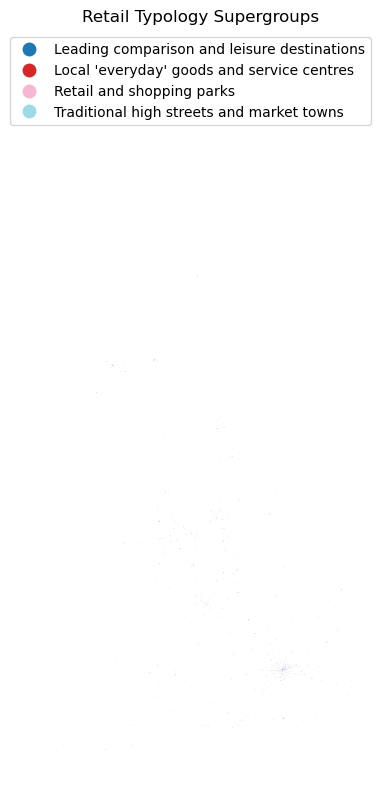

In [60]:
# Plot the typology GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
typology.plot(column="supergroupName", ax=ax, legend=True, cmap="tab20")
ax.set_title("Retail Typology Supergroups")
ax.set_axis_off()
plt.show()

#### 1.2.2. Spatial intersection

In [124]:
# Step 1: Spatial intersection
intersected = gpd.overlay(mobile_locF_gdf, typology, how='intersection')

# Step 2: Add area column for filtering
intersected['area'] = intersected.geometry.area

# Step 3: Sort by area descending so largest is on top
intersected_sorted = intersected.sort_values('area', ascending=False)

# Step 4: Drop duplicates, keeping only the largest (first) for each ID
retail_areas = intersected_sorted.drop_duplicates(
    subset=['Local_Footprint_Centre_ID', 'date'], 
    keep='first'
)

# drop the temporary area column if no longer needed
retail_areas = retail_areas.drop(columns='area')

In [125]:
print(len(locF_gdf))
len(retail_areas)

2999


524131

In [126]:
display(retail_areas.head())

,date,id,events,weekend,season,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,Tourism Score,...,Minor_Class_Name,Seasonality_Class,Seasonality_Class_Name,RC_ID,RC_Name,supergroupID,supergroupName,groupID,groupName,geometry
436970,2024-01-07,17519,475,True,Winter,23-0014-22,65064,767.0,802.0,39.411581,...,Shopping Park,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."
436969,2024-01-06,17519,1365,True,Winter,23-0014-22,65064,767.0,802.0,39.411581,...,Shopping Park,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."
436988,2024-01-25,17519,394,False,Winter,23-0014-22,65064,767.0,802.0,39.411581,...,Shopping Park,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."
436971,2024-01-08,17519,575,False,Winter,23-0014-22,65064,767.0,802.0,39.411581,...,Shopping Park,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."
436979,2024-01-16,17519,741,False,Winter,23-0014-22,65064,767.0,802.0,39.411581,...,Shopping Park,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"POLYGON ((558658.855 178000.076, 558656.199 17..."


In [127]:
# write the retail_areas GeoDataFrame to a GeoPackage
retail_areas.to_file("retail_areas.gpkg", layer="retail_areas", driver="GPKG")

In [79]:
retail_areas = gpd.read_file("retail_areas.gpkg", layer="retail_areas")

In [81]:
# precompute centroids
retail_areas['centroid'] = retail_areas.geometry.centroid

# prepare output columns
retail_areas['rainfall'] = np.nan
retail_areas['tasmax'] = np.nan
retail_areas['tasmin'] = np.nan

### 1.3. Weather Data

#### 1.3.1 Loading in

Rainfall data:

In [63]:
import xarray as xr
import glob

# get all .nc files in the folder
files = sorted(glob.glob("Data/rainfall/*.nc"))

# load and combine along the time dimension
rain_ds = xr.open_mfdataset(files, combine='by_coords')

# check the structure
print(rain_ds)

<xarray.Dataset> Size: 156MB
Dimensions:                       (time: 366, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2024-01-01T12:00:...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    rainfall                      (time, projection_y_coordinate, projection_x_coordinate) float64 153MB dask.array<chunksize=(31, 290, 180), meta=np.ndarray>
    transverse_mercator           (time) int32 1kB -214

Max temperature:

In [64]:
# get all .nc files in the folder
files = sorted(glob.glob("Data/maxtemp/*.nc"))

# load and combine along the time dimension
maxtemp_ds = xr.open_mfdataset(files, combine='by_coords')

# check the structure
print(maxtemp_ds)

<xarray.Dataset> Size: 156MB
Dimensions:                       (time: 366, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2024-01-01T12:00:...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tasmax                        (time, projection_y_coordinate, projection_x_coordinate) float64 153MB dask.array<chunksize=(31, 290, 180), meta=np.ndarray>
    transverse_mercator           (time) int32 1kB -214

Min temperature:

In [65]:
# get all .nc files in the folder
files = sorted(glob.glob("Data/mintemp/*.nc"))

# load and combine along the time dimension
mintemp_ds = xr.open_mfdataset(files, combine='by_coords')

# check the structure
print(mintemp_ds)

<xarray.Dataset> Size: 156MB
Dimensions:                       (time: 366, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2024-01-01T12:00:...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    tasmin                        (time, projection_y_coordinate, projection_x_coordinate) float64 153MB dask.array<chunksize=(31, 290, 180), meta=np.ndarray>
    transverse_mercator           (time) int32 1kB -214

Merge grids:

In [66]:
rain_ds = rain_ds.drop_vars('time_bnds', errors='ignore')
maxtemp_ds = maxtemp_ds.drop_vars('time_bnds', errors='ignore')
mintemp_ds = mintemp_ds.drop_vars('time_bnds', errors='ignore')

merged_ds = xr.merge([rain_ds, maxtemp_ds, mintemp_ds])

In [67]:
print(merged_ds)

<xarray.Dataset> Size: 462MB
Dimensions:                       (time: 366, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 3kB 2024-01-01T12:00:...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB dask.array<chunksize=(290, 180), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    rainfall                      (time, projection_y_coordinate, projection_x_coordinate) float64 153MB dask.array<chunksize=(31, 290, 180), meta=np.ndarray>
    transverse_mercator           (time) int32 1kB -214

#### 1.3.2 Join to mobile data

In [ ]:
# convert NetCDF time to date only for matching
netcdf_dates = pd.to_datetime(merged_ds['time'].values).date
date_to_time_index = {date: idx for idx, date in enumerate(netcdf_dates)}

In [82]:
from geopandas import GeoSeries

# matching retail format
retail_areas['date'] = retail_areas['date'].dt.date  # extract date
# ensure geometry is in WGS84
retail_areas = retail_areas.to_crs("EPSG:4326")
# reproject centroids to WGS84
retail_areas['centroid'] = GeoSeries(retail_areas['centroid'], crs="EPSG:27700").to_crs("EPSG:4326")
# extract lon/lat from reprojected centroids
retail_areas['centroid_x'] = retail_areas['centroid'].x  # longitude
retail_areas['centroid_y'] = retail_areas['centroid'].y  # latitude

In [83]:
# extract lat/lon and make grid
lat_grid = merged_ds['latitude'].values  # shape (290, 180)
lon_grid = merged_ds['longitude'].values  # shape (290, 180)

Extract weather variables:

In [84]:
from tqdm import tqdm

# loop by date group
for date, group in tqdm(retail_areas.groupby('date'), desc="Processing by date"):
    if date not in date_to_time_index:
        continue

    t_idx = date_to_time_index[date]

    # extract weather data for that date
    rain_t = merged_ds['rainfall'].isel(time=t_idx).values
    tmax_t = merged_ds['tasmax'].isel(time=t_idx).values
    tmin_t = merged_ds['tasmin'].isel(time=t_idx).values

    for idx, row in group.iterrows():
        # get centroid coords
        lon_pt, lat_pt = row['centroid_x'], row['centroid_y']

        # find nearest grid cell
        dist_sq = (lon_grid - lon_pt) ** 2 + (lat_grid - lat_pt) ** 2
        i, j = np.unravel_index(dist_sq.argmin(), dist_sq.shape)

        if i >= rain_t.shape[0] or j >= rain_t.shape[1]:
            continue

        # assign values back to main df
        retail_areas.at[idx, 'rainfall'] = rain_t[i, j]
        retail_areas.at[idx, 'tasmax'] = tmax_t[i, j]
        retail_areas.at[idx, 'tasmin'] = tmin_t[i, j]

Processing by date: 100%|██████████| 366/366 [01:17<00:00,  4.72it/s]


In [86]:
retail_areas['date'] = pd.to_datetime(retail_areas['date'])
target_date = pd.to_datetime('2024-09-02').date()  # date object
# Filter retail_areas for the target_date and where rainfall is not NaN
filtered_rain = retail_areas[
    (retail_areas['date'].dt.date == target_date) & 
    (~retail_areas['rainfall'].isna())
]
display(filtered_rain)

,date,id,events,weekend,season,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,Tourism Score,...,supergroupName,groupID,groupName,geometry,centroid,rainfall,tasmax,tasmin,centroid_x,centroid_y
143,2024-09-02,17519,1173,False,Summer,23-0014-22,65064,767.0,802.0,39.411581,...,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",POINT (0.27721 51.48464),1.189453,22.658203,17.374023,0.277208,51.484639
469,2024-09-02,21649,2048,False,Summer,30-0014-22,119923,707.0,738.0,43.798752,...,Retail and shopping parks,2.2,Secondary retail parks and shopping centres,"MULTIPOLYGON (((1.39419 51.36348, 1.39422 51.3...",POINT (1.39485 51.35918),0.428711,24.911133,17.608398,1.394852,51.359179
931,2024-09-02,26011,564,False,Summer,37-0014-22,28022,504.0,524.0,19.488811,...,Retail and shopping parks,2.2,Secondary retail parks and shopping centres,"MULTIPOLYGON (((-1.04342 53.98527, -1.04348 53...",POINT (-1.04712 53.98623),0.085938,20.848633,15.643555,-1.047118,53.986227
1418,2024-09-02,35864,64,False,Summer,63-0069-22,19701,229.0,237.0,25.218743,...,Retail and shopping parks,2.2,Secondary retail parks and shopping centres,"MULTIPOLYGON (((-4.47732 55.84771, -4.47696 55...",POINT (-4.47239 55.84542),17.220703,15.705078,14.320312,-4.472393,55.845425
1821,2024-09-02,13522,399,False,Summer,15-0012-22,55299,371.0,386.0,7.349800,...,Retail and shopping parks,2.2,Secondary retail parks and shopping centres,"MULTIPOLYGON (((-1.28214 54.57728, -1.282 54.5...",POINT (-1.28312 54.57442),0.516602,20.616211,14.994141,-1.283122,54.574424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522486,2024-09-02,6876,47,False,Summer,06-0274-22,2579,97.0,93.0,26.137064,...,Local 'everyday' goods and service centres,1.2,District urban service centres,"MULTIPOLYGON (((-1.58944 54.97566, -1.58948 54...",POINT (-1.58947 54.97569),0.037109,19.132812,15.551758,-1.589473,54.975694
522963,2024-09-02,10461,45,False,Summer,09-0134-22,3990,190.0,180.0,64.831122,...,Local 'everyday' goods and service centres,1.1,Local urban convenience centres,"MULTIPOLYGON (((-2.58954 51.46502, -2.58955 51...",POINT (-2.58953 51.46504),2.607422,21.267578,18.312500,-2.589534,51.465039
523059,2024-09-02,29424,21,False,Summer,43-0344-22,64479,633.0,705.0,28.196997,...,Leading comparison and leisure destinations,3.2,Sub-regional retail and leisure destinations,"MULTIPOLYGON (((0.70907 52.24696, 0.70905 52.2...",POINT (0.70905 52.24698),3.571289,22.602539,16.431641,0.709053,52.246976
523523,2024-09-02,855,126,False,Summer,01-0848-22,22396,287.0,269.0,143.858839,...,Leading comparison and leisure destinations,3.1,Large regional retail and leisure destinations,"MULTIPOLYGON (((-0.07518 51.54091, -0.0752 51....",POINT (-0.07519 51.54095),0.875000,21.865234,18.524414,-0.075187,51.540947


Double check duplicates:

In [87]:
num_unique_ids = retail_areas['id'].nunique()
print(f"Number of unique ids: {num_unique_ids}")

Number of unique ids: 1448


In [ ]:
# check for duplicate rows in retail_areas based on all columns
duplicate_rows = retail_areas.duplicated()
print(f"Number of completely duplicated rows: {duplicate_rows.sum()}")

# check for duplicate IDs per date (should be unique for each date/id)
duplicate_id_date = retail_areas.duplicated(subset=['id', 'date'])
print(f"Number of duplicated (id, date) pairs: {duplicate_id_date.sum()}")

# show some examples if any duplicates exist
if duplicate_id_date.any():
    display(retail_areas[duplicate_id_date].head())

Number of completely duplicated rows: 0
Number of duplicated (id, date) pairs: 0


------------- TRIAL W/ SEPT DATA -------------

In [169]:
## open the NetCDF file
rain_ds = xr.open_dataset("Data/sept2024/rainfall_hadukgrid_uk_5km_day_20240901-20240930.nc")
rainfall = rain_ds['rainfall']

# view dataset structure
display(rain_ds)

<xarray.Dataset> Size: 13MB
Dimensions:                       (time: 30, projection_y_coordinate: 290,
                                   projection_x_coordinate: 180, bnds: 2)
Coordinates:
  * time                          (time) datetime64[ns] 240B 2024-09-01T12:00...
  * projection_y_coordinate       (projection_y_coordinate) float64 2kB -1.97...
  * projection_x_coordinate       (projection_x_coordinate) float64 1kB -1.97...
    latitude                      (projection_y_coordinate, projection_x_coordinate) float64 418kB ...
    longitude                     (projection_y_coordinate, projection_x_coordinate) float64 418kB ...
Dimensions without coordinates: bnds
Data variables:
    rainfall                      (time, projection_y_coordinate, projection_x_coordinate) float64 13MB ...
    transverse_mercator           int32 4B ...
    time_bnds                     (time, bnds) datetime64[ns] 480B ...
    projection_y_coordinate_bnds  (projection_y_coordinate, bnds) float64 5kB ...
    projection_x_coordinate_bnds  (projection_x_coordinate, bnds) float64 3kB ...
Attributes:
    comment:        Daily resolution gridded climate observations
    creation_date:  2024-10-07T17:50:51
    frequency:      day
    institution:    Met Office
    references:     doi: 10.1002/gdj3.78
    short_name:     daily_rainfall
    source:         HadUK-Grid_Provisional
    title:          Gridded surface climate observations data for the UK
    version:        provisional
    Conventions:    CF-1.7

#### 1.3.2. Trial merge with rainfall data

In [170]:
# convert NetCDF time to date only for matching
netcdf_dates = pd.to_datetime(rain_ds['time'].values).date
date_to_time_index = {date: idx for idx, date in enumerate(netcdf_dates)}

# matching retail format
retail_areas['date'] = retail_areas['date'].dt.date  # extract date
# ensure geometry is in WGS84
retail_areas = retail_areas.to_crs("EPSG:4326")

In [176]:
# extract lat/lon and make grid
lat_grid = rain_ds['latitude'].values  # shape (290, 180)
lon_grid = rain_ds['longitude'].values  # shape (290, 180)

In [177]:
def get_rainfall_for_polygon(row):
    poly_date = row['date']
    if poly_date not in date_to_time_index:
        return np.nan

    t_idx = date_to_time_index[poly_date]
    rainfall_t = rainfall.isel(time=t_idx).values  # shape (290, 180)

    centroid = row.geometry.centroid
    lon_pt, lat_pt = centroid.x, centroid.y  # in EPSG:4326 (WGS84)

    # Calculate squared distance to all grid points
    dist_sq = (lon_grid - lon_pt)**2 + (lat_grid - lat_pt)**2
    i, j = np.unravel_index(dist_sq.argmin(), dist_sq.shape)

    # Optional: sanity check bounds
    if i >= rainfall_t.shape[0] or j >= rainfall_t.shape[1]:
        return np.nan

    return rainfall_t[i, j]

In [179]:
retail_areas[['rainfall', 'tmax', 'tmin']] = retail_areas.apply(get_weather_for_polygon, axis=1)

In [180]:
retail_areas['date'] = pd.to_datetime(retail_areas['date'])
target_date = pd.to_datetime('2024-09-02').date()  # date object
# Filter retail_areas for the target_date and where rainfall is not NaN
filtered_rain = retail_areas[
    (retail_areas['date'].dt.date == target_date) & 
    (~retail_areas['rainfall'].isna())
]
display(filtered_rain)

,date,id,events,weekend,season,Local_Footprint_Centre_ID,Residential Population (Weighted Catchment),Retail Footprint Score,Base Score,Tourism Score,...,Seasonality_Class,Seasonality_Class_Name,RC_ID,RC_Name,supergroupID,supergroupName,groupID,groupName,geometry,rainfall
143,2024-09-02,17519,1173,False,Summer,23-0014-22,65064,767.0,802.0,39.411581,...,1,Not seasonal,RC_EW_2382,Lakeside Shopping Centre; Thurrock (East of En...,2,Retail and shopping parks,2.1,Primary shopping centres and premium destinations,"MULTIPOLYGON (((0.28337 51.47871, 0.28334 51.4...",1.189453
469,2024-09-02,21649,2048,False,Summer,30-0014-22,119923,707.0,738.0,43.798752,...,1,Not seasonal,RC_EW_1335,Margate Road; Westwood; Thanet (South East; En...,2,Retail and shopping parks,2.2,Secondary retail parks and shopping centres,"MULTIPOLYGON (((1.39419 51.36348, 1.39422 51.3...",0.428711
931,2024-09-02,26011,564,False,Summer,37-0014-22,28022,504.0,524.0,19.488811,...,1,Not seasonal,RC_EW_735,Monks Cross Retail Park; York (Yorkshire and T...,2,Retail and shopping parks,2.2,Secondary retail parks and shopping centres,"MULTIPOLYGON (((-1.04342 53.98527, -1.04348 53...",0.085938
1418,2024-09-02,35864,64,False,Summer,63-0069-22,19701,229.0,237.0,25.218743,...,1,Not seasonal,RC_SC_18,Paisley Leisure Park; Renfrewshire (Scotland),2,Retail and shopping parks,2.2,Secondary retail parks and shopping centres,"MULTIPOLYGON (((-4.47732 55.84771, -4.47696 55...",17.220703
1821,2024-09-02,13522,399,False,Summer,15-0012-22,55299,371.0,386.0,7.349800,...,1,Not seasonal,RC_EW_1234,Portrack Interchange Retail Park; Stockton-on-...,2,Retail and shopping parks,2.2,Secondary retail parks and shopping centres,"MULTIPOLYGON (((-1.28214 54.57728, -1.282 54.5...",0.516602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
522486,2024-09-02,6876,47,False,Summer,06-0274-22,2579,97.0,93.0,26.137064,...,1,Not seasonal,RC_EW_5770,Shields Road; Byker; Newcastle upon Tyne (Nort...,1,Local 'everyday' goods and service centres,1.2,District urban service centres,"MULTIPOLYGON (((-1.58944 54.97566, -1.58948 54...",0.037109
522963,2024-09-02,10461,45,False,Summer,09-0134-22,3990,190.0,180.0,64.831122,...,1,Not seasonal,RC_EW_3523,Stokes Croft; Cotham; City of Bristol (South W...,1,Local 'everyday' goods and service centres,1.1,Local urban convenience centres,"MULTIPOLYGON (((-2.58954 51.46502, -2.58955 51...",2.607422
523059,2024-09-02,29424,21,False,Summer,43-0344-22,64479,633.0,705.0,28.196997,...,1,Not seasonal,RC_EW_2702,Bury St Edmunds; West Suffolk (East of England...,3,Leading comparison and leisure destinations,3.2,Sub-regional retail and leisure destinations,"MULTIPOLYGON (((0.70907 52.24696, 0.70905 52.2...",3.571289
523523,2024-09-02,855,126,False,Summer,01-0848-22,22396,287.0,269.0,143.858839,...,1,Not seasonal,RC_EW_1979,"Dalston, London (London; England)",3,Leading comparison and leisure destinations,3.1,Large regional retail and leisure destinations,"MULTIPOLYGON (((-0.07518 51.54091, -0.0752 51....",0.875000


Double check duplicates:

In [189]:
num_unique_ids = retail_areas['id'].nunique()
print(f"Number of unique ids: {num_unique_ids}")

Number of unique ids: 1448
